<font size ="4">**Importing all the libraries**</font>

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os


from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import neighbors , metrics , svm

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/u194149/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u194149/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/u194149/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [4]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [5]:
fake_data = pd.read_csv('data/Fake.csv')
# fake_data.head()

In [6]:
true_data = pd.read_csv('data/True.csv')
# true_data.head()

Assigning Classes to the Dataset

In [7]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [8]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

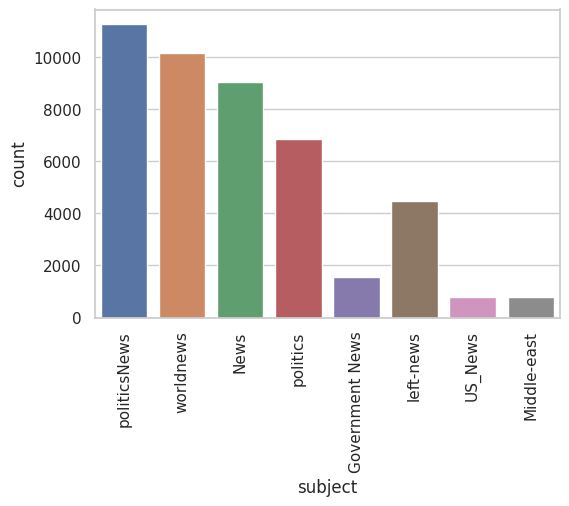

In [9]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<font size="4">**Data preprocessing**</font>

In [10]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [11]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [12]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [13]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [14]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,Key U.S. senator remains concerned over ChemCh...,1
1,Twitter Erupts With Glee Over #CruzSexScandal...,0
2,5-YEAR OLD SUSPENDED FROM SCHOOL For Playing W...,0
3,Charlottesville: Far Left vs Far Right Clashes...,0
4,"Myanmar violence could spread, displace more R...",1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

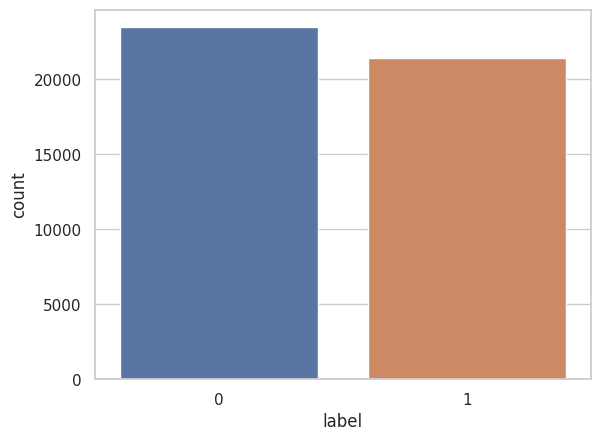

In [15]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

     Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as   input.


**Tokenization**
      
      1.We use the method of word_tokenize() to split sentence into words.
      2.Is helpful to convert the text:string into numeric values to train the model
      
**Stemming**
      
      1.We use to remove the same meaning word from the text(dataset)
      
      2.Example
        if we have ['dance' , 'dancing' , 'danced'] = words
        by using the stemming process words --> stemming process -> output : ['dance' , 'dance' , 'dance']
        stemming process will cut down the suffix of the word

**Lemmatization**
      
      1.Instead of using the Stemming we can also use the lemmatization which provide the better performance output
      and it also perform based on  morphological analysis
      
      2.Example ['Alice' , 'Studies' , 'Studying'] --> lemmatizer process -> output : ['Alice' , 'Studies' , 'Study']


In [16]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def preprocess_text(text):
    
    text = text.lower()
    

    lemmatizer = WordNetLemmatizer()
    text = word_tokenize(text)

    for i in text:
        lemmatizer.lemmatize(i)
    
    stopword = set(stopwords.words('english'))
    stopword.update(list(string.punctuation))
    stopword.update(['"'])
    
    word = str()
    for i in text:
        if i not in stopword:
            word += i
            word += " "
    


    
    return word

data['text'] = data['text'].apply(preprocess_text)

<font size="4">**Converting text into Vectors**</font>

**CountVectorizer**
            
     Is a text vectorization method provided by the scikit-learn library in Python. It is a simple and commonly used technique that converts a collection of text documents into a matrix of token counts.

In [17]:
#TODO: explore different vectorization available with sklearn.feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

x , y = data['text'] , data['label']

vector = CountVectorizer()
x = vector.fit_transform(x)


<font size="4">**Spliting the data for the model**</font>

**train_test_split**

    function is used to separate the (x,y) : dependent and independent values to train and test data in which the train variable are used to train the dataset and test datasets are used to test and find the prediction of model

In [18]:
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = 0.4)

<font size="4">**Model training, Evaluation, and Prediction**</font>

<font size = 4>**Logistic Regression Model**<font>

In [19]:
LR = LogisticRegression(max_iter = 200)
LR.fit(x_train , y_train)

LogisticRegression(max_iter=200)

In [20]:
scoreLogisticRegression = accuracy_score(LR.predict(x_test) , y_test)
print("The Accuracy Score of the LogisticRegression %.2f " % scoreLogisticRegression,end = "% out of 1.0")

The Accuracy Score of the LogisticRegression 1.00 % out of 1.0

In [21]:
print(classification_report(y_test , LR.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9313
           1       1.00      1.00      1.00      8647

    accuracy                           1.00     17960
   macro avg       1.00      1.00      1.00     17960
weighted avg       1.00      1.00      1.00     17960



In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
dtc_pred = (LR.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixLR = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, LR.predict(x_test)):
    confusion_matrixLR[true][predict] += 1

print(confusion_matrixLR)

[[9281.   32.]
 [  14. 8633.]]


<font size = 4>**Random Forest Algorithm**<font>

In [24]:
RF = RandomForestClassifier(criterion = 'gini' , max_depth = 8 , min_samples_split = 10 , random_state = 5)
RF.fit(x_train , y_train)

RandomForestClassifier(max_depth=8, min_samples_split=10, random_state=5)

In [25]:
scoreRandomForest = accuracy_score(RF.predict(x_test) , y_test)
print("The Accuracy Score of the Random Forest %.2f " % scoreRandomForest,end = "% out of 1.0")

The Accuracy Score of the Random Forest 0.98 % out of 1.0

In [26]:
print(classification_report(y_test , RF.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9313
           1       0.99      0.96      0.98      8647

    accuracy                           0.98     17960
   macro avg       0.98      0.98      0.98     17960
weighted avg       0.98      0.98      0.98     17960



In [27]:
dtc_pred = (RF.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixRF = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, RF.predict(x_test)):
    confusion_matrixRF[true][predict] += 1

print(confusion_matrixRF)

[[9244.   69.]
 [ 306. 8341.]]


<font size = 4>**Navie Bayes Algorithm**<font>

In [28]:
NF = MultinomialNB()
NF.fit(x_train , y_train)

MultinomialNB()

In [29]:
scoreNavieBayes = accuracy_score(NF.predict(x_test) , y_test)
print("The Accuracy Score of the Navie Bayes %.2f " % scoreNavieBayes,end = "% out of 1.0")

The Accuracy Score of the Navie Bayes 0.96 % out of 1.0

In [30]:
print(classification_report(NF.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      9383
           1       0.96      0.96      0.96      8577

    accuracy                           0.96     17960
   macro avg       0.96      0.96      0.96     17960
weighted avg       0.96      0.96      0.96     17960



In [31]:
dtc_pred = (NF.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixNF = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, NF.predict(x_test)):
    confusion_matrixNF[true][predict] += 1

print(confusion_matrixNF)

[[8998.  315.]
 [ 385. 8262.]]


<font size = 4>**Support Vector Machine**<font>

**About SVM**
  
    * SVM was a supervised classfication algorithm The goal of the SVM algorithm is to create the best line or decision boundary that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future.
    
    * SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors.
    
    * Separating Hyperplane: SVM aims to find an optimal hyperplane that separates the data points of different classes with the largest possible margin. The hyperplane is a decision boundary in the feature space.
    
    * Support Vectors: Support vectors are the data points that lie closest to the hyperplane. These points are critical in defining the decision boundary. Only the support vectors contribute to the construction of the SVM model, while other data points are ignored.
    
    
 
**Types of SVM**
       
    1. Linear Support Vector Machine
      * It was 2-dimensional space and the data will be segregate by using linear line as marign.
      * Compare the Non - Linear SVM the Linear model more simpler and efficient to predict the accurate data set.
      
    2. Non-Linear Support Vector Machine
      * It was 3-dimensional space and the data for 3d or more than 3-dimensional space will be using a 3d plane to segregate the data.
      * By using linear line could not able to segregate the data as marign but its also a 2d space then its also known as non-linear svm example parabola.
    

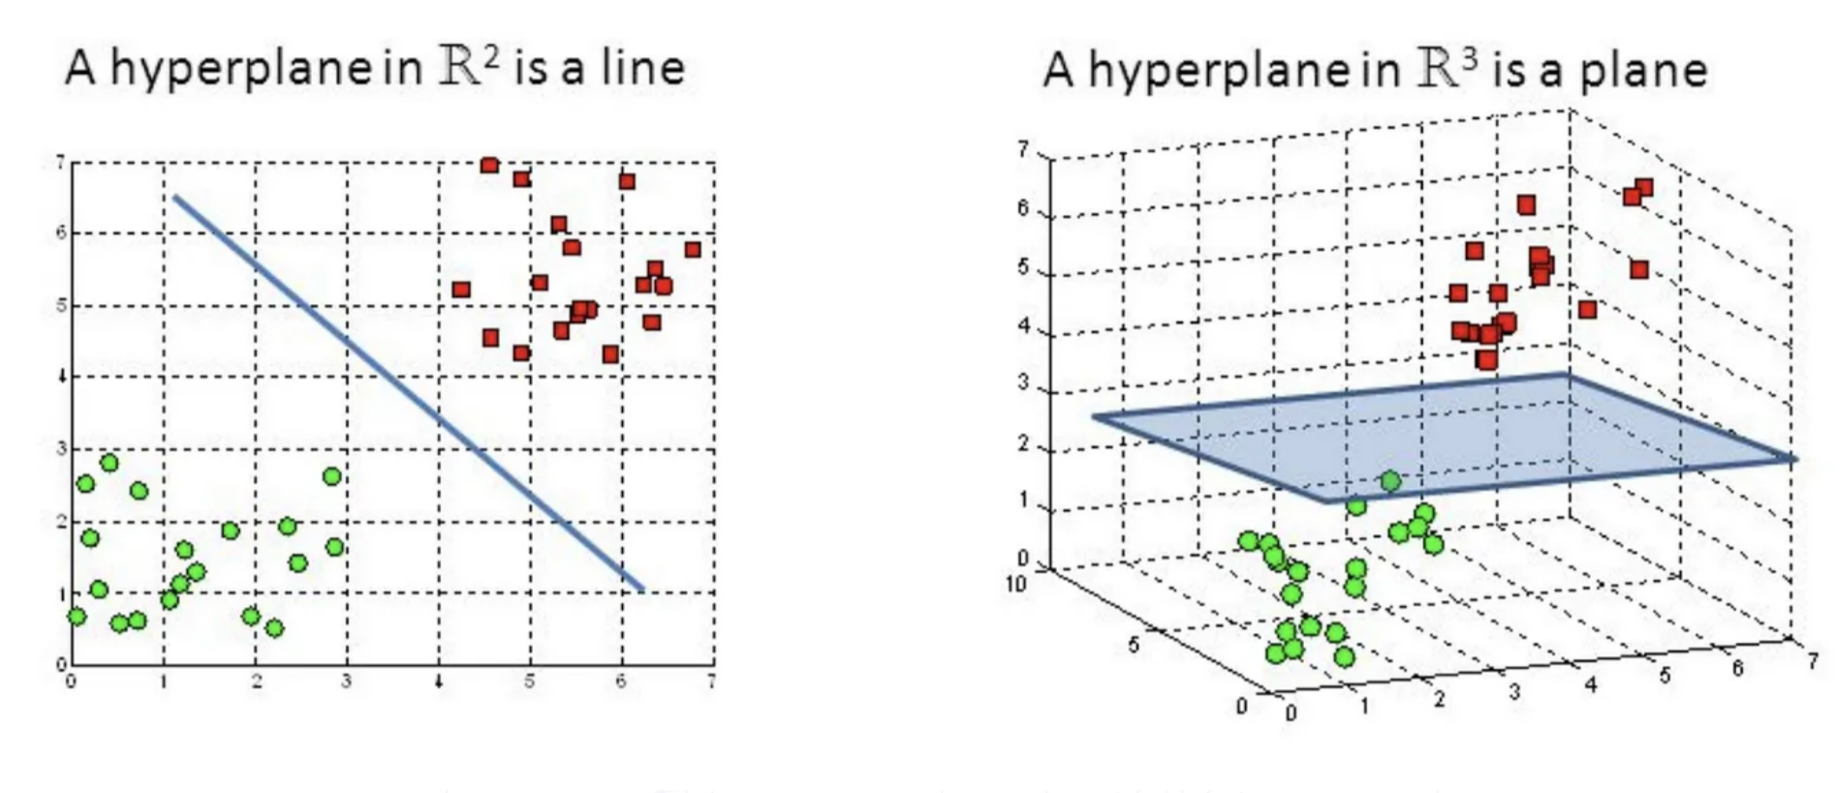

In [32]:
SVM = svm.SVC(kernel = 'linear' , random_state = 1)

In [33]:
SVM.fit(x_train , y_train)

SVC(kernel='linear', random_state=1)

In [34]:
scoreSupportVectorMachine = accuracy_score(SVM.predict(x_test) , y_test)
print("The Accuracy Score of the Support Vector Machine %.2f " % scoreSupportVectorMachine,end = "% out of 1.0")

The Accuracy Score of the Support Vector Machine 1.00 % out of 1.0

In [35]:
print(classification_report(SVM.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9300
           1       1.00      1.00      1.00      8660

    accuracy                           1.00     17960
   macro avg       1.00      1.00      1.00     17960
weighted avg       1.00      1.00      1.00     17960



In [36]:
dtc_pred = (SVM.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixSVM = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, SVM.predict(x_test)):
    confusion_matrixSVM[true][predict] += 1

print(confusion_matrixSVM)

[[9282.   31.]
 [  18. 8629.]]


<font size = 4>**Gradient Boosting**<font>

<font size = 3>
 About Boosting:The principle behind boosting algorithms is first we built a model on the training dataset, then a second model is built to rectify the errors present in the first model.
<font>

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators = 900 , max_features = 5 , learning_rate = 1.2 , random_state = 5)
GB.fit(x_train , y_train)

GradientBoostingClassifier(learning_rate=1.2, max_features=5, n_estimators=900,
                           random_state=5)

In [38]:
scoreGradientBoost = accuracy_score(GB.predict(x_test) , y_test)
print("The Accuracy Score of the Gradient Boosting %.2f " % scoreGradientBoost,end = "% out of 1.0")

The Accuracy Score of the Gradient Boosting 0.90 % out of 1.0

In [39]:
dtc_pred = (GB.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixGB = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, GB.predict(x_test)):
    confusion_matrixGB[true][predict] += 1

print(confusion_matrixGB)

[[8483.  830.]
 [ 977. 7670.]]


In [40]:
scoreGradientBoost = accuracy_score(GB.predict(x_test) , y_test)
print("The Accuracy Score of the Gradient Boosting %.2f " % scoreGradientBoost,end = "% out of 1.0")

The Accuracy Score of the Gradient Boosting 0.90 % out of 1.0

<font size = 4>**Neural Network**<font>

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-07-05 04:16:50.133275: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 04:16:50.189222: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 04:16:50.190015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 04:17:06.003445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-05 04:17:33.002544: E itex/core/kernels/xpu_kernel.cc:38] XPU-GPU kernel not supported.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues


In [42]:
text = np.array(data['text'])

In [43]:
label = np.array(data['label'])

In [44]:
token = Tokenizer()
token.fit_on_texts(text)
word_index = token.word_index
vocab_size = len(word_index) + 1

In [45]:
sequence = token.texts_to_sequences(text)

In [46]:
max_length = max([len(seq) for seq in sequence])

In [47]:
padded = pad_sequences(sequence , maxlen = max_length)

In [48]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size , 16 , input_length = max_length , name = "Embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16 , activation = 'relu'),
    tf.keras.layers.Dense(1 , activation = 'sigmoid')
])

In [49]:
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 5182, 16)          2018816   
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,019,105
Trainable params: 2,019,105
Non-trainable params: 0
_________________________________________________________________


In [51]:
paddedX_train ,paddedX_test ,paddedY_train ,paddedY_test = train_test_split(padded , label , test_size = 0.4)

In [ ]:
model.fit(paddedX_train , paddedY_train , epochs = 7)

2023-07-05 04:18:11.202581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-05 04:18:11.401585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


Epoch 1/7


2023-07-05 04:18:11.446939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


In [ ]:
scoreNeuralNetwork = model.evaluate(paddedX_test , paddedY_test , verbose = 0)

In [ ]:
print("The Accuracy Score of the Neural Network of Sequential Model %.2f " % scoreNeuralNetwork[1],end = "% out of 1.0")

<font size = 4>**Decision Tree Classifier**<font>

**About Decision Tree Classifier Model**
      
    * A decision tree is a popular and widely used machine learning algorithm that resembles a flowchart-like structure, representing decisions and their possible consequences.
    * It is a predictive model used for classification and regression tasks.
    * The decision tree algorithm learns from labelled training data and builds a hierarchical structure of decision nodes and leaf nodes.
    
    * Difference between Decision tree classifier and other machine learning models
      1)Interpretability
        * Decision trees are highly interpretable models. The decision rules inferred from the tree structure can be easily understood and visualized
        * In contrast, some other models, like neural networks or support vector machines, are often considered black-box models, making it harder to interpret their decisions.
        
      2)Nonlinearity
        * Decision trees can capture nonlinear relationships between features and the target variable without requiring explicit feature transformations, This can be advantageous when the underlying data has complex nonlinear patterns.
      
      3)Generalization Performance
        * Decision trees have a tendency to overfit the training data, especially when the tree becomes deep and complex.
        

    * For Example to understand how the decision tree is been created for certain model
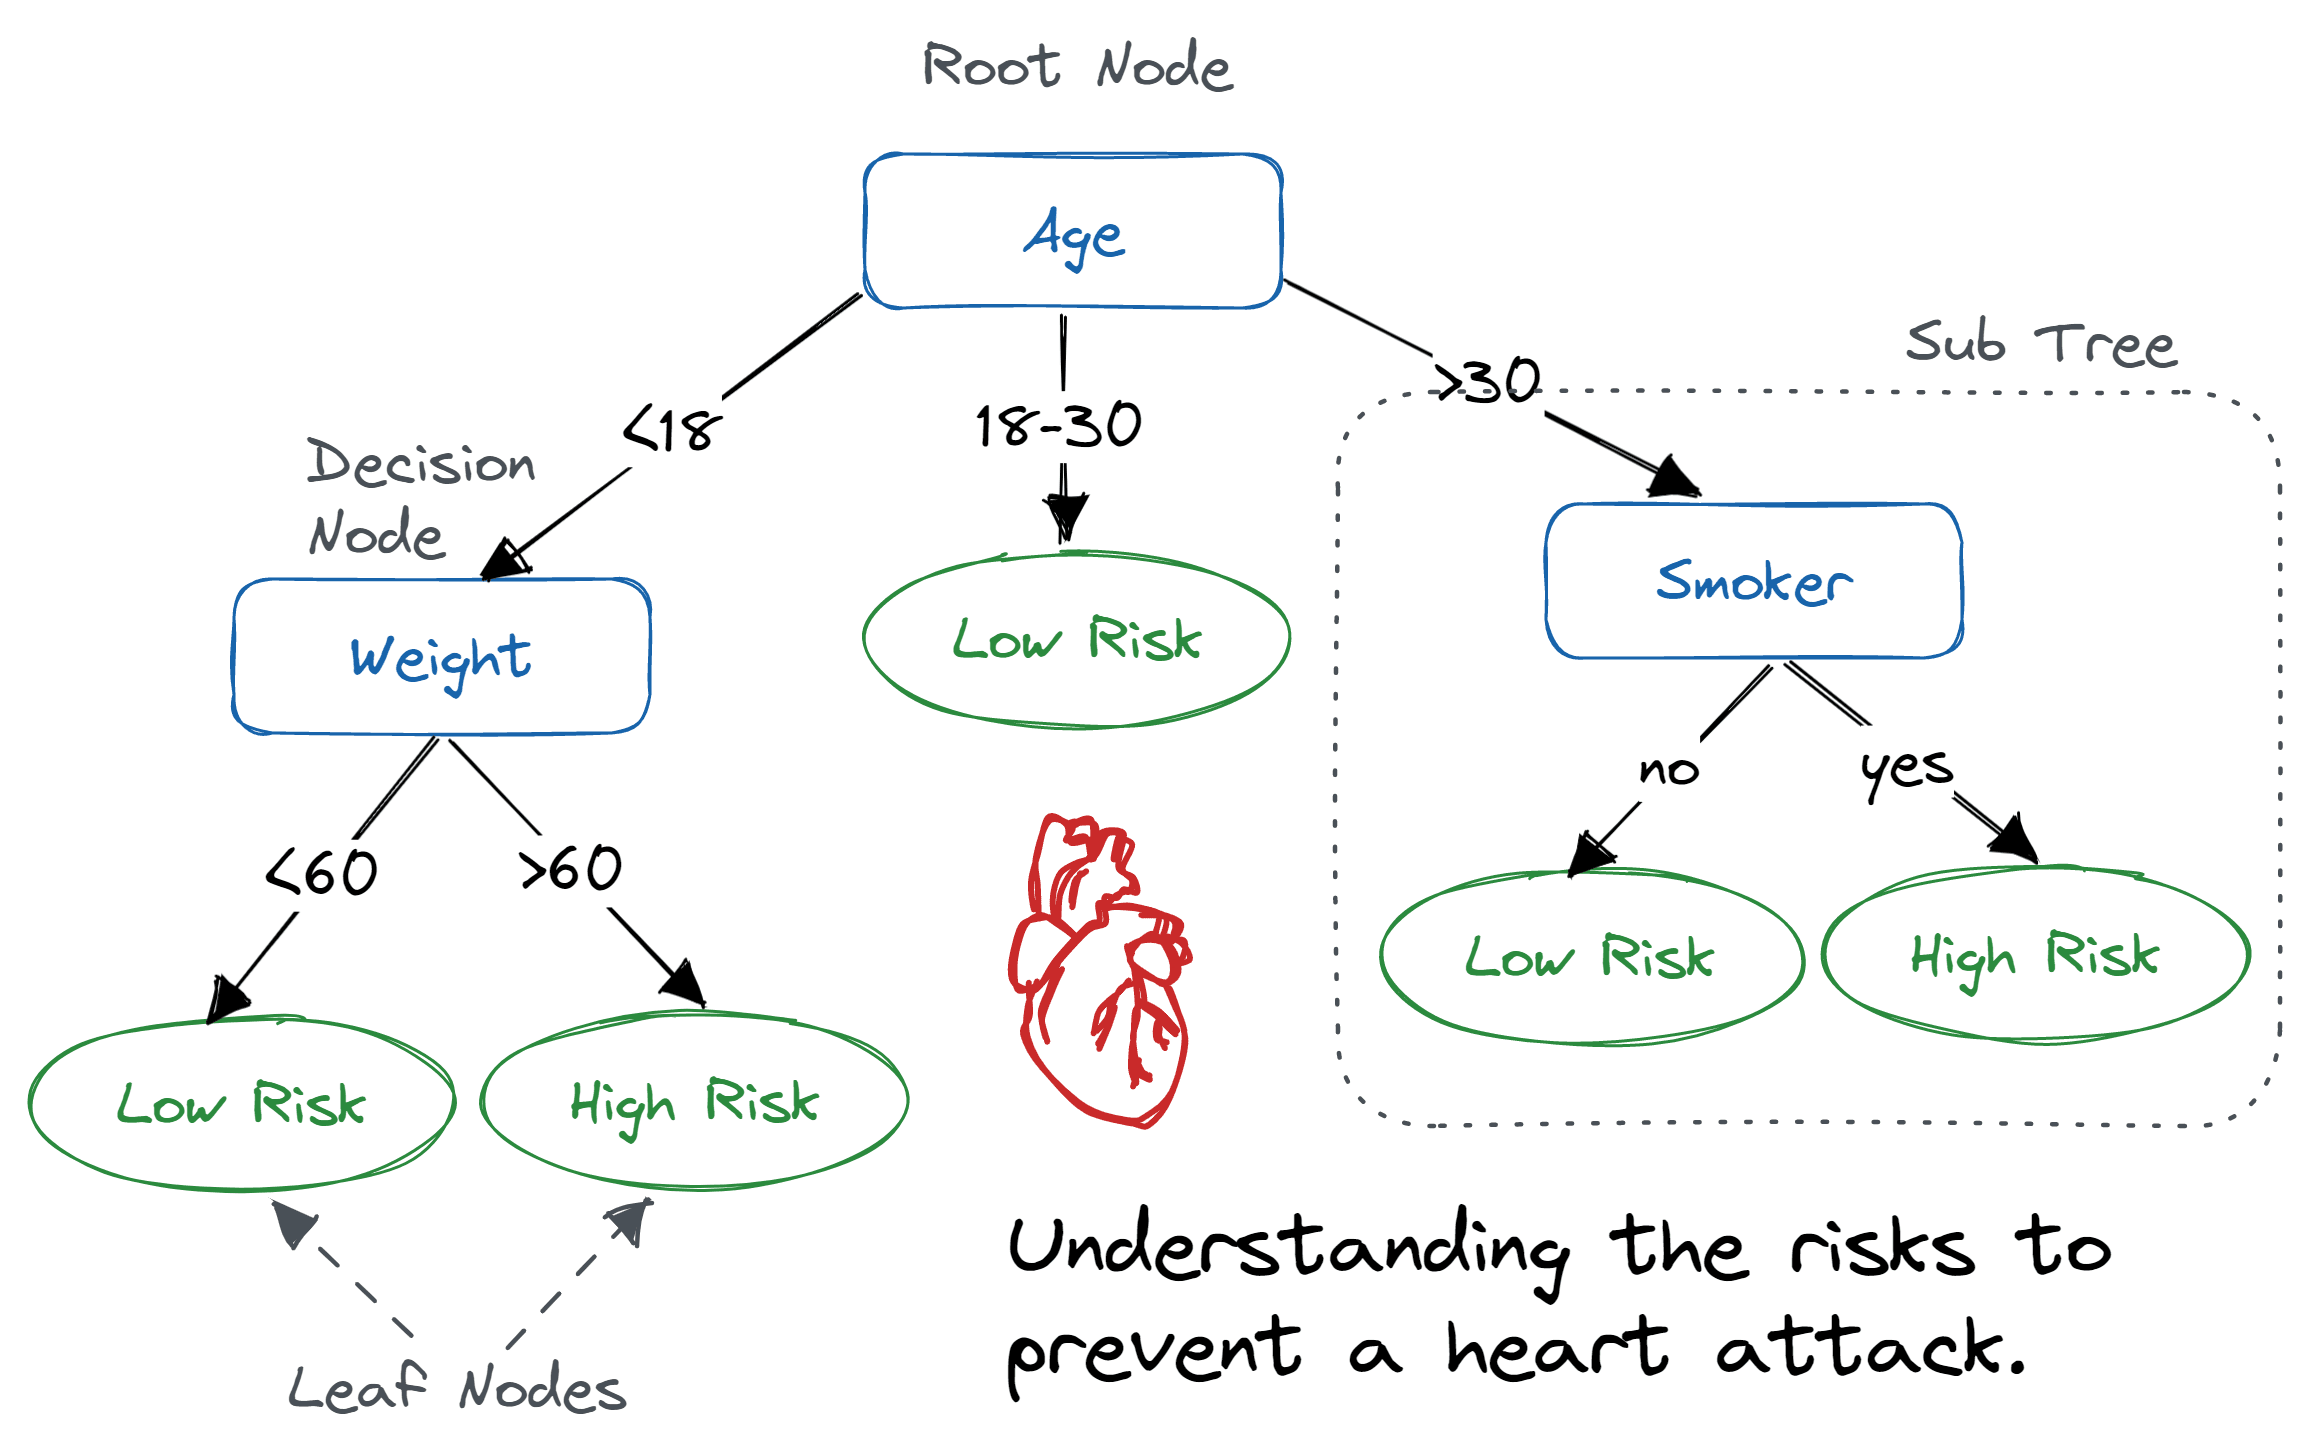

**Syntax of Decision Tree Classifier**
          
    1)DecisionTreeClassifier(criterion = 'entropy' , splitter = 'random') 
      1)criterion = 'entropy' : The function to measure the quality of a split.
         About criterion =  entropy
         
               * he entropy criterion computes the Shannon entropy of the possible classes. It takes the class frequencies of the training data points that reached a given leaf as their probability.
               
      
      2)splitter = 'random' : The strategy used to choose the split at each node. Supported strategies are “random” to choose the best random split.
    

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
DTC = DecisionTreeClassifier(criterion = 'entropy' , splitter = 'random')

In [ ]:
DTC.fit(x_train , y_train)

In [ ]:
scoreDecisionTreeClassifier = accuracy_score(y_test , DTC.predict(x_test))
print("The Accuracy Score of the Decision Tree Classifier %.2f " % scoreDecisionTreeClassifier,end = "% out of 1.0")

In [ ]:
print(classification_report(DTC.predict(x_test) , y_test))

In [ ]:
dtc_pred = (DTC.predict(x_test) > 0.5).astype(int)

num_classes = 2
confusion_matrixDTC = np.zeros((num_classes, num_classes))

for true, predict in zip(y_test, DTC.predict(x_test)):
    confusion_matrixDTC[true][predict] += 1

print(confusion_matrixDTC)